<a href="https://colab.research.google.com/github/Sokolov-AA/ML_Study/blob/main/PlatesBaselineKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c platesv2
# !unzip platesv2.zip
# !unzip plates.zip

# !mv /content/plates/test /content/plates/unknown
# !mkdir /content/plates/test
# !mv /content/plates/unknown /content/plates/test/unknown

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("TensorFlow verison:", tf.__version__)

TensorFlow verison: 2.8.2


In [ ]:
image = tf.io.read_file('/content/plates/test/unknown/0100.jpg')
image = tf.image.decode_jpeg(image, channels=3)
print(image.shape)
input_shape = image.shape

(256, 341, 3)


Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


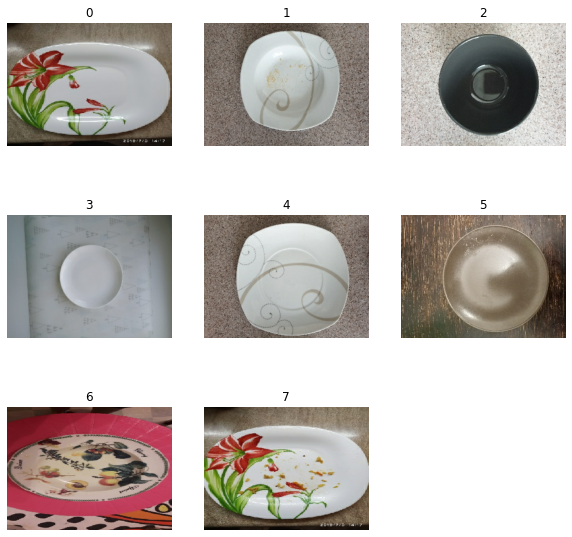

In [ ]:
seed = 42
batch_size=8

ds_train_ = image_dataset_from_directory(
    '/content/plates/train/',
    labels='inferred',
    label_mode='binary',
    image_size=[256, 341],
    interpolation='nearest',
    subset="training",
    validation_split=0.2,
    seed=42,
    batch_size=batch_size,
    shuffle=True)

ds_valid_ = image_dataset_from_directory(
    '/content/plates/train/',
    labels='inferred',
    label_mode='binary',
    image_size=[256, 341],
    interpolation='nearest',
    subset="validation",
    validation_split=0.2,
    seed=42,
    batch_size=batch_size,
    shuffle=True)

# Data Pipeline
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

ds_train = (
    ds_train_
    .map(resize_image)
    .cache()
)
ds_valid = (
    ds_valid_
    .map(resize_image)
    .cache()
)

plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(i)
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential([            
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.9),
  keras.layers.RandomZoom(.5, .5)
])

# train_datagen = keras.preprocessing.image.ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)


# def augmentate_image(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_crop(image, size=(224, 224))
#     return image, label

# ds_train_augmented = (
#     ds_train
#     .map(augmentate_image)
#     .cache()
# )

# plt.figure(figsize=(10, 10))
# for images, labels in ds_train_augmented.take(1):
#   for i in range(8):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(i)
#     plt.axis("off")

In [ ]:
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
#base_model.summary()

In [ ]:
model = keras.Sequential([
    data_augmentation,
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(.4),
    keras.layers.Dense(1, activation='sigmoid')
])



In [ ]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
  loss="binary_crossentropy",
  metrics=['accuracy'])


history = model.fit(
  ds_train,
  validation_data=ds_valid,
  epochs=200
)

Epoch 1/200
4/4 [==============================] - 8s 360ms/step - loss: 0.8200 - accuracy: 0.5312 - val_loss: 12.4256 - val_accuracy: 0.5000
Epoch 2/200
4/4 [==============================] - 0s 69ms/step - loss: 0.5791 - accuracy: 0.7812 - val_loss: 7.8585 - val_accuracy: 0.5000
Epoch 3/200
4/4 [==============================] - 0s 55ms/step - loss: 0.6905 - accuracy: 0.6250 - val_loss: 8.1668 - val_accuracy: 0.5000
Epoch 4/200
4/4 [==============================] - 0s 53ms/step - loss: 0.5130 - accuracy: 0.7812 - val_loss: 7.5369 - val_accuracy: 0.5000
Epoch 5/200
4/4 [==============================] - 0s 53ms/step - loss: 0.4775 - accuracy: 0.7812 - val_loss: 6.0584 - val_accuracy: 0.5000
Epoch 6/200
4/4 [==============================] - 0s 52ms/step - loss: 0.5125 - accuracy: 0.7500 - val_loss: 3.6963 - val_accuracy: 0.5000
Epoch 7/200
4/4 [==============================] - 0s 55ms/step - loss: 0.3301 - accuracy: 0.8438 - val_loss: 2.6771 - val_accuracy: 0.6250
Epoch 8/200
4/4 [=

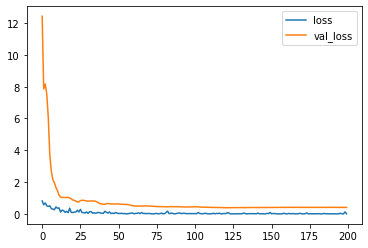

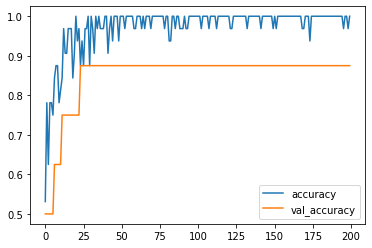

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
ds_test_ = keras.preprocessing.image_dataset_from_directory(
    "/content/plates/test/", 
    image_size=[256, 341],
    shuffle=False
)

ds_test = (
    ds_test_
    .map(resize_image)
    .cache()
)

Found 744 files belonging to 1 classes.


In [ ]:
prediction = model.predict(ds_test)

In [ ]:
test_prediction = [prediction[i][0] for i in range(len(prediction))]
submission_df = pd.DataFrame.from_dict({'id': ds_test_.file_paths, 'label': test_prediction})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
ds_train_all_ = keras.preprocessing.image_dataset_from_directory(
    "/content/plates/train/", 
    image_size=[256, 341],
    shuffle=False
)

ds_train_all = (
    ds_train_all_
    .map(resize_image)
    .cache()
)

Found 40 files belonging to 2 classes.


In [ ]:
prediction_train_all = model.predict(ds_train_all)

In [ ]:
train_prediction = [prediction_train_all[i][0] for i in range(len(prediction_train_all))]
submission_df = pd.DataFrame.from_dict({'id': ds_train_all_.file_paths, 'label': train_prediction})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.head(n=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,label
id,
/content/plates/train/cleaned/0000,cleaned
/content/plates/train/cleaned/0001,cleaned
/content/plates/train/cleaned/0002,cleaned
/content/plates/train/cleaned/0003,cleaned
/content/plates/train/cleaned/0004,cleaned
/content/plates/train/cleaned/0005,cleaned
/content/plates/train/cleaned/0006,cleaned
/content/plates/train/cleaned/0007,cleaned
/content/plates/train/cleaned/0008,cleaned
